In [20]:
import numpy as np
from scipy.stats import zscore
import scipy.sparse as sps
from scipy.special import expit
import matplotlib.pyplot as plt
%matplotlib inline

### Instantiate a glm object

The only required parameter is the distribution. 
At present, ```pyglmnet``` supports ```poisson```, ```binomial```, or ```normal```.

In [21]:
import pyglmnet as pyglmnet


model = pyglmnet.glm('poisson')

### Simulate a dataset
The ```glm``` class has a very useful method called ```simulate()```. 

Since a canonical link function is already specified by the distribution parameters, or provided by the user, ```simulate()``` requires on the independent variables ```x``` and the coefficients ```beta0``` and ```beta```

In [22]:
# Dataset size
N = 10000
p = 100

# Coefficients

# baseline term
beta0 = np.random.normal(0.0, 1.0, 1)
# sparse model terms
beta = sps.rand(p,1,0.1)
beta = np.array(beta.todense())

# Training data
xr = np.random.normal(0.0, 1.0, [N,p])
yr = model.simulate(beta0, beta, xr)

# Test data
xt = np.random.normal(0.0, 1.0, [N,p])
yt = model.simulate(beta0, beta, xt)


### Fit the model
Fitting the model is accomplished by a single ```glm``` method called ```fit()```.

In addition to the independent variables ```x``` and target variables ```y```, ```fit()``` accepts two dictionaries ```reg_params``` and ```opt_params``` as parameters.

```reg_params``` has two fields:
* ```reg_lambda``` is a vector of $\lambda$'s that specify the regularization path.
* ```alpha``` is a scalar the determins the balance between $\mathcal{l}_1$ and $\mathcal{l}_2$ regularization. ```alpha``` = 0 is ridge, ```alpha``` = 1 is lasso, everything in between is elastic net.

```opt_params``` has two fields:
* ```learning_rate``` is the learning rate for batch gradient descent. At present, a heuristic choice of $10^{-4}$ seems to work well. You might need to decrease the learning rate for large ```N```.
* ```max_iter``` is the maximum number of iterations before gradient descent is aborted. Typical problems converge at around 20 iterations.

```verbose=True (False)``` sets (on) off convergence information. Default is ```True```.

```fit()``` returns a list of dictionaries for each ```lambda```. Each element contains a scalar beta0 and a vector beta of estimated coefficients

In [23]:
# Set regularization parameters
reg_lambda = np.logspace(np.log(0.5), np.log(0.01), 10, base=np.exp(1))
alpha = 0.05

reg_params = dict()
reg_params['reg_lambda'] = reg_lambda
reg_params['alpha'] = alpha

# Set optimization parameters
opt_params = dict()
opt_params['learning_rate'] = 1e-4
opt_params['max_iter'] = 1000

# Fit model to training data
fit = model.fit(zscore(xr),yr,reg_params,opt_params,verbose='False')


### Visualize the fit coefficients

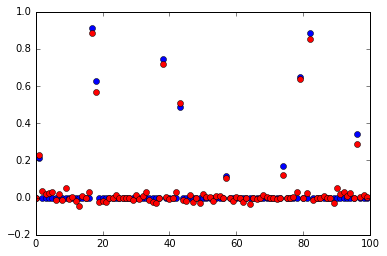

In [24]:
# Visualize estimated coefficients
fitparams = fit[-2]
plt.plot(beta[:], 'bo')
plt.hold(True)
plt.plot(fitparams['beta'][:], 'ro')
plt.show()

### Make predictions based on fit model
The ```predict()``` method takes two parameters: a numpy 2d array of independent variables and a dictionary of fit parameters. It returns a vector of predicted targets.



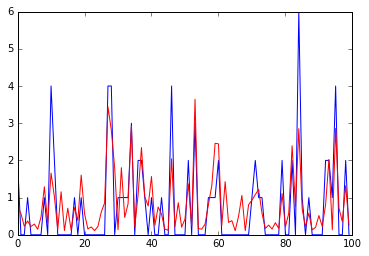

In [25]:
# Predict targets from test set
yrhat = model.predict(zscore(xr), fitparams)
ythat = model.predict(zscore(xt), fitparams)

plt.plot(yt[:100])
plt.hold(True)
plt.plot(ythat[:100], 'r')
plt.show()

### Goodness of fit

The ```glm``` class provides two methods for evaluating goodness of fit: ```deviance()``` and ```pseudo_R2()```. Both of them require the true targets and the predicted targets as inputs. ```pseudo_R2()``` additionally requires a null model, which is typically the mean of the target variables in the training set.

In [26]:
# Compute model deviance
Dr = model.deviance(yr, yrhat)
Dt = model.deviance(yt, ythat)
print Dr, Dt

8317.01867129 8229.17926626


In [27]:
# Compute pseudo-R2s
R2r = model.pseudo_R2(yr, yrhat, np.mean(yr))
R2t = model.pseudo_R2(yt, ythat, np.mean(yr))
print R2r, R2t

0.430124046752 0.424718888917


### Optionally specify your own exponential family distribution
If you wish to use your own distribution other than the ones provided, you need to provide three functions. 
* A nonlinearity (inverse link function), given by the method ```qu()```.
* A corresponding log-likelihood, given by the method ```logL()```.
* A corresponding gradient of the $\mathcal{l}_2$ loss given by method ```grad_L2loss()```.

Here is a example that gives each of those functions for the Poisson GLM implementation in ```pyglmnet```.

In [43]:
# Example nonlinearity (aka inverse link function)
def qu(z):
    eps = 0.1
    q = np.log(1+eps+np.exp(z))
    return q
model.qu = qu

# Example log-likelihood
def logL(beta0, beta, x, y):
    l = model.lmb(beta0, beta, x)
    logL = np.sum(y*np.log(l) - l)
    return logL
model.logL = logL

# Example gradient term
def grad_L2loss(beta0, beta, alpha, reg_lambda, x, y):
    z = beta0 + np.dot(x, beta)
    q = model.qu(z)
    s = expit(z)
    grad_beta0 = np.sum(s) - np.sum(y*s/q)
    grad_beta = np.transpose(np.dot(np.transpose(s), x) - np.dot(np.transpose(y*s/q), x)) \
                + reg_lambda*(1-alpha)*beta
    return grad_beta0, grad_beta
model.grad_L2loss = grad_L2loss